# Fitting

There are two built in fitting engines, `lmfit` and `bumps`.

Set current directory.

In [16]:
os.chdir('/Users/andrewsazonov/Development/Projects/easyScience/easyDiffractionLib/tests')

In [17]:
import os
tests_path = os.getcwd()
os.chdir(os.path.join(os.getcwd(), '..'))
eDL_path = os.getcwd()
print("Test path:", tests_path)
print("easyDiffractionLib path:", eDL_path)

Test path: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffractionLib/tests
easyDiffractionLib path: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffractionLib


Import all the packages.

In [8]:
# Import all the packages
from easyCore import np
from easyDiffractionLib.sample import Sample
from easyDiffractionLib import Phases
from easyDiffractionLib.interface import InterfaceFactory
from easyDiffractionLib.Elements.Experiments.Experiment import Pars1D
from easyDiffractionLib.Elements.Experiments.Pattern import Pattern1D

from easyCore.Fitting.Fitting import Fitter

import matplotlib.pyplot as plt

GSAS-II binary directory: /Users/andrewsazonov/Library/Caches/pypoetry/virtualenvs/easydiffractionlib-P2avuC9_-py3.7/lib/python3.7/site-packages/libsDarwin/GSASII/bindist


## Preparing the sample and data

We load up a cif file and then set the experimental parameters.

In [25]:
interface = InterfaceFactory()
cif_path = os.path.join(tests_path, 'PbSO4.cif')
print('cif_path:', cif_path)
c = Phases.from_cif_file(cif_path)
S = Sample(phases=c, parameters=Pars1D.default(), pattern=Pattern1D.default(), interface=interface)

cif_path: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffractionLib/tests/PbSO4.cif
Temp CIF: /var/folders/vj/bjjkqpsx4js6s242h0t_h45sf5f66_/T/easydiffraction_temp.cif


We can load up some experimental data

In [26]:
xye_path = os.path.join(tests_path, 'PbSO4_xrays_short.xye')
print('xye_path:', xye_path)
data_x, data_y, data_e = np.loadtxt(xye_path, unpack=True)
print('data_x:', data_x)
print('data_y:', data_y)
print('data_e:', data_e)

xye_path: /Users/andrewsazonov/Development/Projects/easyScience/easyDiffractionLib/tests/PbSO4_xrays_short.xye
data_x: [ 10.     10.025  10.05  ... 119.95  119.975 120.   ]
data_y: [179. 147. 165. ... 163. 164. 166.]
data_e: [13.3791 12.1244 12.8452 ... 12.7671 12.8062 12.8841]


Generate the simulation y-data

In [28]:
sim_y_data = interface.fit_func(data_x)

y_calc: [0.000e+00 0.000e+00 0.000e+00 ... 5.094e-27 5.598e-27 4.636e-27]


<IPython.core.display.Javascript object>


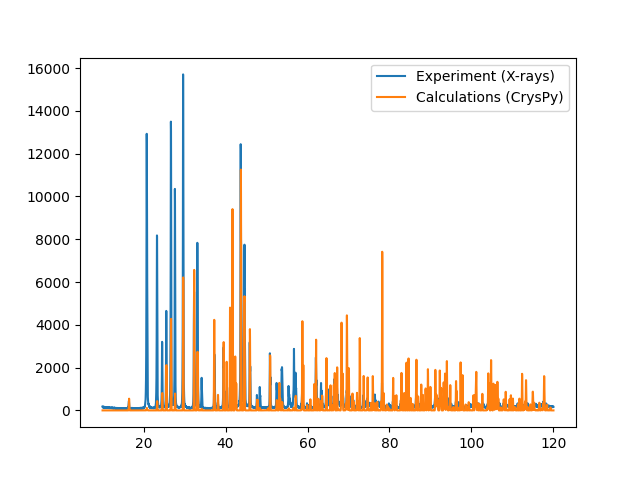

In [29]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

We do not have the correct experimental parameters..

<IPython.core.display.Javascript object>


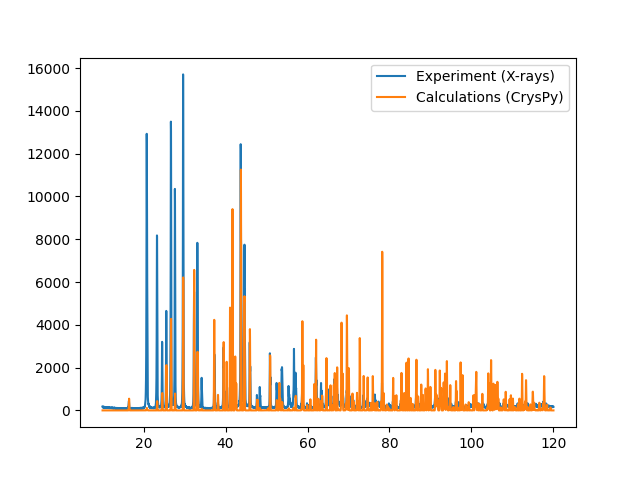

In [30]:
S.parameters.wavelength = 1.54
S.parameters.u_resolution = 0.031
S.parameters.v_resolution = -0.052
S.parameters.w_resolution = 0.032
S.parameters.x_resolution = 0.015
S.parameters.y_resolution = 0.0

#sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Now we need to set the background

In [31]:
from easyDiffractionLib.Elements.Backgrounds.Point import PointBackground, BackgroundPoint

bg = PointBackground(linked_experiment='PbSO4')
bg.append(BackgroundPoint.from_pars(data_x[0], 166))
bg.append(BackgroundPoint.from_pars(16, 36))
bg.append(BackgroundPoint.from_pars(50, 120))
bg.append(BackgroundPoint.from_pars(100, 100))
bg.append(BackgroundPoint.from_pars(data_x[-1], 164))
print(bg)

S.set_background(bg)
print(S.backgrounds)

Background of 5 points.
Collection of 1 backgrounds.


y_calc: [166.    165.458 164.917 ... 163.84  164.777 167.43 ]


<IPython.core.display.Javascript object>


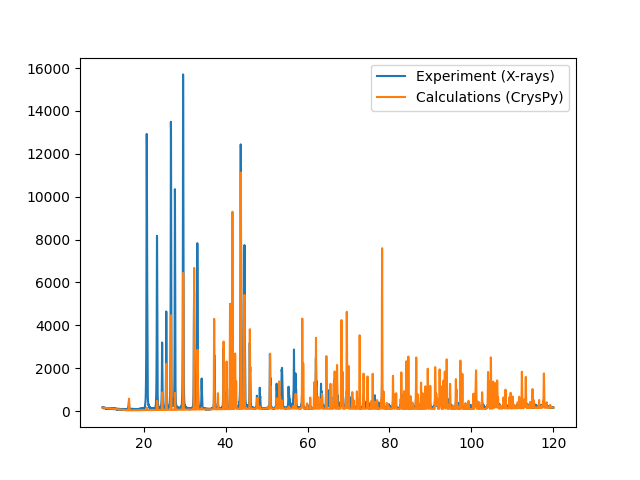

In [32]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Select CrysFML calculator

In [33]:
print(interface.available_interfaces)
print(interface.current_interface_name)
interface.switch('CrysFML')
S._updateInterface()
print(interface.current_interface_name)

['CrysPy', 'CrysFML', 'GSAS-II']
CrysPy
CrysFML


y_calc: [166.    165.458 164.917 ... 171.525 171.95  173.582]


<IPython.core.display.Javascript object>


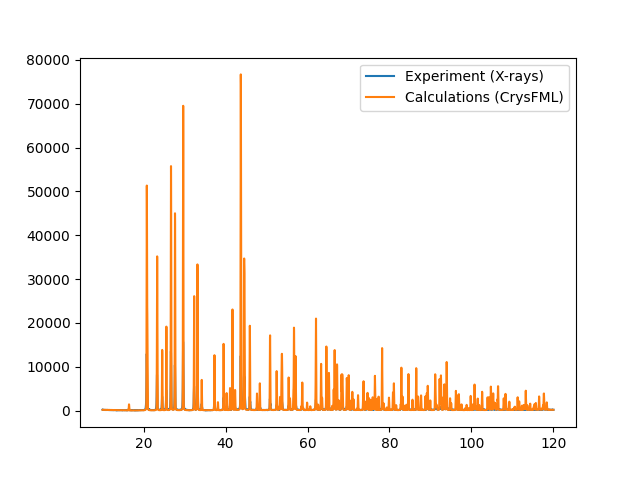

In [34]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Change scale manually

y_calc: [166.    165.458 164.917 ... 164.608 164.723 164.958]


<IPython.core.display.Javascript object>


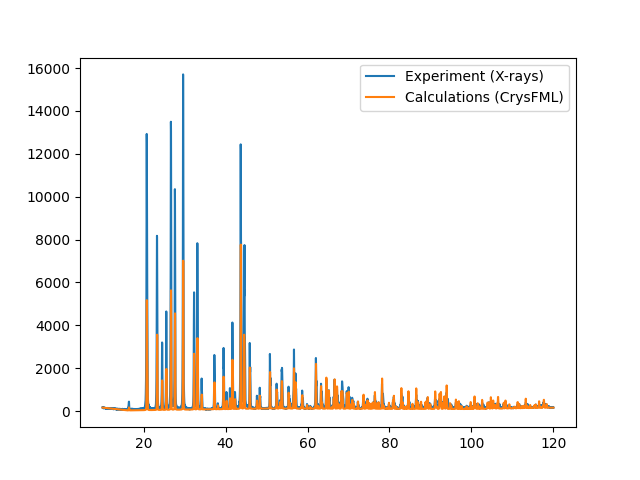

In [35]:
S.pattern.scale = 0.1
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

## Fitting to the data

Initalize the fitting engine and apply a few constraints

In [36]:
f = Fitter(S, interface.fit_func)

# Vary the scale and the BG points
S.pattern.scale.fixed = False
S.pattern.zero_shift.fixed = False
#S.parameters.resolution_u.fixed = False
#S.parameters.resolution_v.fixed = False
#S.parameters.resolution_w.fixed = False
#S.parameters.resolution_x.fixed = False
#S.backgrounds[0][0].y.fixed = False
#S.backgrounds[0][1].y.fixed = False
#S.backgrounds[0][2].y.fixed = False
#S.backgrounds[0][3].y.fixed = False
#S.backgrounds[0][4].y.fixed = False

Select bumps minimizer

In [37]:
print("available minimizers:", f.available_engines)
print()
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())
print()
print("switch minimizer")
f.switch_engine('bumps')
f_method = 'lm'
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())

available minimizers: ['lmfit', 'bumps']

current minimizer: lmfit
available methods of current minimizer: ['leastsq', 'least_squares', 'differential_evolution', 'basinhopping', 'ampgo', 'nelder', 'lbfgsb', 'powell', 'cg', 'newton', 'cobyla', 'bfgs']

switch minimizer
current minimizer: bumps
available methods of current minimizer: ['amoeba', 'de', 'dream', 'newton', 'lm', 'mp', 'pt']


Perform the fit

In [38]:
result = f.fit(data_x, data_y, weights=1/data_e, method=f_method)

y_calc: [166.    165.458 164.917 ... 164.608 164.723 164.958]
y_calc: [166.    165.458 164.917 ... 164.724 164.844 165.102]
y_calc: [162.75  162.208 161.667 ... 165.165 165.216 165.357]
y_calc: [1.107e-07 2.767e+01 5.533e+01 ... 1.641e+02 1.642e+02 1.644e+02]
y_calc: [164.375 163.833 163.292 ... 164.942 165.027 165.241]
y_calc: [2.213e-07 5.533e+01 1.107e+02 ... 1.644e+02 1.645e+02 1.647e+02]
y_calc: [165.188 164.646 164.104 ... 164.83  164.924 165.119]
y_calc: [165.188 164.646 164.104 ... 164.954 165.055 165.278]
y_calc: [164.781 164.24  163.698 ... 165.127 165.213 165.474]
y_calc: [166.    165.458 164.917 ... 164.839 164.964 165.246]
y_calc: [8.853e-07 1.659e+02 1.653e+02 ... 1.648e+02 1.650e+02 1.653e+02]
y_calc: [165.188 164.646 164.104 ... 165.077 165.187 165.437]
y_calc: [166.    165.458 164.917 ... 164.954 165.084 165.389]
y_calc: [8.853e-07 1.659e+02 1.653e+02 ... 1.650e+02 1.651e+02 1.654e+02]
y_calc: [4.427e-07 1.107e+02 1.657e+02 ... 1.647e+02 1.649e+02 1.651e+02]
y_calc: [1

y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]
y_calc: 

In [39]:
if result.success:
    print("The fit has been successful: {}".format(result.success))
    print("The gooodness of fit is: {}".format(result.goodness_of_fit))
    
sim_y_data = interface.fit_func(data_x)

The fit has been successful: True
The gooodness of fit is: 1507313994654.0708
y_calc: [165.68  165.139 164.597 ... 165.634 165.802 166.2  ]


<IPython.core.display.Javascript object>


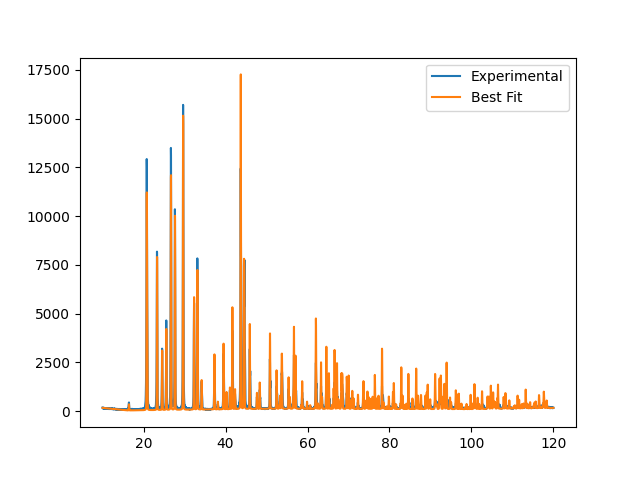

In [40]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experimental')
plt.plot(data_x, sim_y_data, label='Best Fit')
plt.legend()

In [41]:
print(f'Scale: {S.pattern.scale}')
print(f'Scale: {S.pattern.zero_shift}')

Scale: <Parameter 'scale': 0.2216+/-0.0000, bounds=[-inf:inf]>
Scale: <Parameter 'zero_shift': 0.0148+/-0.0000 deg, bounds=[-inf:inf]>
